# Comparing POT Solvers

In this example we will consider two images in CIFAR-10 as the source and target distributions, and compute a transport map between them.

In [1]:
import numpy as np
import matplotlib.image as img
import seaborn as sns
import matplotlib.pyplot as plt

## Set up the experiment

### Download the CIFAR-10 dataset

In [2]:
## Download from Alex Krizhevsky's CIFAR-10 page
# !curl https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -o cifar-10-python.tar.gz
# !tar -xf cifar-10-python.tar.gz

In [3]:
# Download the zipped file
# Batches 0...5 = trainingset, 6 = test set
batches = [f"cifar-10-batches-py/data_batch_{i}" for i in range(1, 6)]
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

In [4]:
training_batches = [unpickle(batch) for batch in batches]
x_train = np.concatenate([batch[b"data"] for batch in training_batches])

# Reshape and rescale to [0, 1]
x_train = x_train.reshape(50000, 3, 32, 32).transpose(0, 2, 3, 1).astype(float) / 255

y_train = np.concatenate([batch[b"labels"] for batch in training_batches])

In [5]:
classes = ["airplane", "automobile", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck"]

### Choose two images

In [6]:
# Change the indices below to change the pictures
source_idx, target_idx = 204, 1

# Get the images and rescale to [0, 1]
source_rgb = x_train[source_idx,:,:,:].reshape(32, 32, 3)
target_rgb = x_train[target_idx,:,:,:].reshape(32, 32, 3)

# Labels for these images
source_label = classes[y_train[source_idx]]
target_label = classes[y_train[target_idx]]

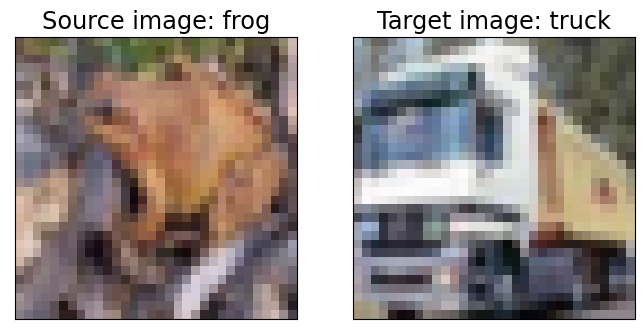

In [7]:
# Display these images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 20))

# Source image
ax1.imshow(source_rgb)
ax1.set_title(f"Source image: {source_label}", size="xx-large")
ax1.set_xticks([]); ax1.set_yticks([])

# Target image
ax2.imshow(target_rgb)
ax2.set_title(f"Target image: {target_label}", size="xx-large")
ax2.set_xticks([]); ax2.set_yticks([])
plt.show()

### Convert the images to grayscale

In [8]:
from skimage.color import rgb2gray

source_grayscale = rgb2gray(source_rgb).reshape(32, 32)
target_grayscale = rgb2gray(target_rgb).reshape(32, 32)

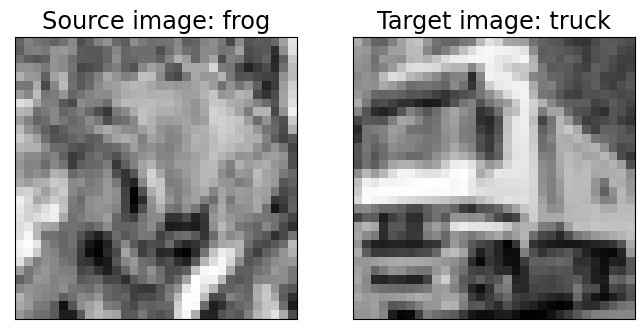

In [9]:
# Display these images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 20))

# Source image
ax1.imshow(source_grayscale, cmap="gray")
ax1.set_title(f"Source image: {source_label}", size="xx-large")
ax1.set_xticks([]); ax1.set_yticks([])

# Target image
ax2.imshow(target_grayscale, cmap="gray")
ax2.set_title(f"Target image: {target_label}", size="xx-large")
ax2.set_xticks([]); ax2.set_yticks([])
plt.show()

### Downscale the images

In [10]:
from skimage.transform import resize
# The new images will be of shape (new_d, new_d)
new_d = 10

source_grayscale_small = resize(source_grayscale, (new_d, new_d))
target_grayscale_small = resize(target_grayscale, (new_d, new_d))

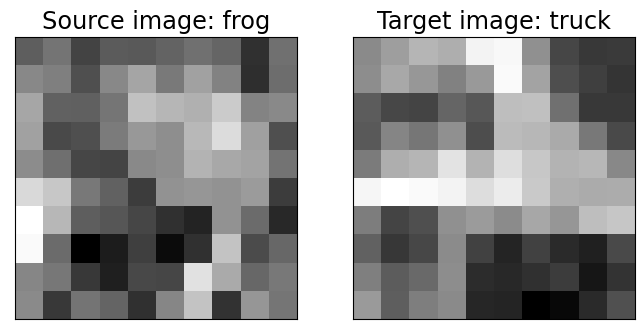

In [11]:
# Display these images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 20))

# Source image
ax1.imshow(source_grayscale_small, cmap="gray")
ax1.set_title(f"Source image: {source_label}", size="xx-large")
ax1.set_xticks([]); ax1.set_yticks([])

# Target image
ax2.imshow(target_grayscale_small, cmap="gray")
ax2.set_title(f"Target image: {target_label}", size="xx-large")
ax2.set_xticks([]); ax2.set_yticks([])
plt.show()

### Compute the cost matrix

We will use the downscaled grayscale images as sources and targets.

Assume that each image is a matrix of shape $d \times d$, we flatten each image so that the distributions are vectors of shape $(n, )$, where $n = d^2$.

The cost matrix is of shape $n \times n$. We use the squared Euclidean distance as follows

$$
\begin{align*}
C_{d i + j, d k + l} = (i - k) ^ 2 + (j - l) ^ 2,
\end{align*}
$$
for all $i, j, k, l = 1, \ldots, d.$

Finally, we normalize the cost matrix so the maximum entry is 1.

In [12]:
# n = dimensions of the source and target histograms
n = new_d * new_d

# Cost matrix
C = np.zeros((n, n), dtype=float)
for i in range(new_d):
    for j in range(new_d):
        for k in range(new_d):
            for l in range(new_d):
                row = i * new_d + j
                col = k * new_d + l
                C[row, col] = (i - k) ** 2 + (j - l) ** 2
C = C / np.max(C)

# C = ot.dist(np.arange(n, dtype=float).reshape((n, 1)), np.arange(n).reshape((n, 1)))
# C /= np.max(C)

### Finalize and plot

In [13]:
# Flatten the images
source_hist = source_grayscale_small.flatten()
target_hist = target_grayscale_small.flatten()

# Ensure that every bin is non-zero
eps = 1e-6
source_hist += eps
target_hist += eps

# Normalize so the maximum total mass is 1
max_mass = max(source_hist.sum(), target_hist.sum())
source_hist /= max_mass
target_hist /= max_mass

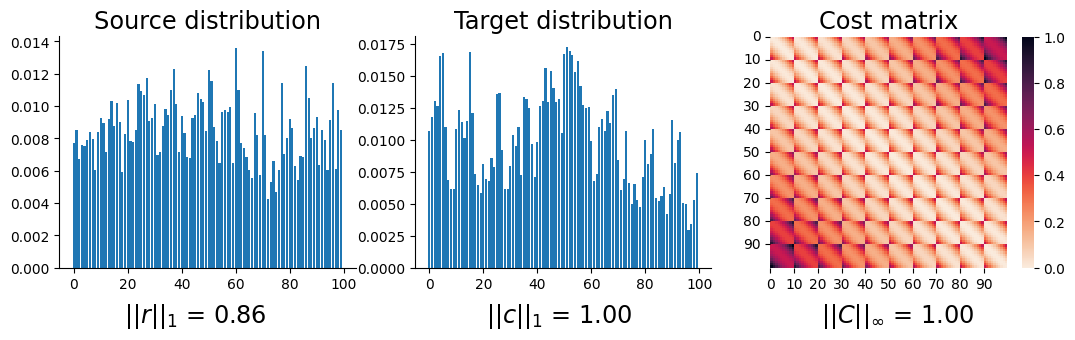

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 3))

# Plot source distribution
ax1.bar(np.arange(len(source_hist)), source_hist)
ax1.set_title(f"Source distribution", size="xx-large")
fig.text(x=0.23, y=-0.05, s=f"$\\|\\| r \\|\\|_1$ = {source_hist.sum():.2f}", 
         size="xx-large", va="center", ha="center")
sns.despine(ax=ax1)

# Plot target distribution
ax2.bar(np.arange(len(target_hist)), target_hist)
ax2.set_title(f"Target distribution", size="xx-large")
fig.text(x=0.51, y=-0.05, s=f"$\\|\\| c \\|\\|_1$ = {target_hist.sum():.2f}", 
         size="xx-large", va="center", ha="center")
sns.despine(ax=ax2)

# Plot cost matrix
sns.heatmap(C, cmap=sns.color_palette("rocket_r", as_cmap=True), ax=ax3)
ax3.set_title("Cost matrix", size="xx-large")
fig.text(x=0.77, y=-0.05, s=f"$\\|\\| C \\|\\|_\\infty$ = {C.max():.2f}", 
         size="xx-large", va="center", ha="center")
ax3.set_xticks(np.arange(0, n, 10), np.arange(0, n, 10), rotation=0)
ax3.set_yticks(np.arange(0, n, 10), np.arange(0, n, 10), rotation=0)

plt.show()

## Run POT solvers

In [15]:
# Set the mass to be transported
min_mass = min(source_hist.sum(), target_hist.sum())
s = 0.8 * min_mass

### Linear programming

In [16]:
from pot_solvers.lp import lp
X_lp = lp(source_hist, target_hist, C, s, tol=1e-24, verbose=False)
f_star = np.sum(X_lp * C)
f_star

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-30


0.0

### APDAGD

In [34]:
from pot_solvers.apdagd import apdagd
T_apdagd, logs_apdagd = apdagd(source_hist, target_hist,
                               C, s=s, tol=1e-2, verbose=True, print_every=1000,
                               check_termination=False, num_iters=10000,
                               # gamma=1e-1
                              )

Regularization parameter: gamma = 5.43e-04
Tolerance for duality gap        : 6.25e-04
Tolerance for ||X1 + p - a||_2   : 6.25e-04
Tolerance for ||X.T 1 + q - b||_2: 6.25e-04
Tolerance for ||1.T X 1 - s||_2  : 6.25e-04
Iter =  1000 | Duality gap = 6.79e-06 | ||Ax - b|| = 1.58e-04 | L estimate = 1024.0
Iter =  2000 | Duality gap = 1.72e-06 | ||Ax - b|| = 4.00e-05 | L estimate = 2048.0
Iter =  3000 | Duality gap = 7.60e-07 | ||Ax - b|| = 1.77e-05 | L estimate = 1024.0
Iter =  4000 | Duality gap = 4.28e-07 | ||Ax - b|| = 9.98e-06 | L estimate = 1024.0
Iter =  5000 | Duality gap = 2.76e-07 | ||Ax - b|| = 6.44e-06 | L estimate = 1024.0
Iter =  6000 | Duality gap = 1.94e-07 | ||Ax - b|| = 4.52e-06 | L estimate =  512.0
Iter =  7000 | Duality gap = 1.50e-07 | ||Ax - b|| = 3.49e-06 | L estimate = 2048.0
Iter =  8000 | Duality gap = 1.20e-07 | ||Ax - b|| = 2.79e-06 | L estimate = 4096.0
Iter =  9000 | Duality gap = 9.95e-08 | ||Ax - b|| = 2.32e-06 | L estimate =  256.0
Iter = 10000 | Duality ga

### Sinkhorn

In [35]:
from pot_solvers.sinkhorn import sinkhorn
T_sinkhorn, logs_sinkhorn = sinkhorn(source_hist, target_hist,
                                     C, s=s, tol=1e-2, verbose=True, print_every=1000,
                                     check_termination=False, num_iters=10000,
                                     # gamma=1e-1
                                    )

Regularization parameter: gamma = 5.42e-04
Sinkhorn tolerance      : tol   = 5.68e-04
Iter =  1000 | Loss = 7.66e-16
Iter =  2000 | Loss = 7.53e-16
Iter =  3000 | Loss = 7.50e-16
Iter =  4000 | Loss = 7.66e-16
Iter =  5000 | Loss = 7.53e-16
Iter =  6000 | Loss = 7.50e-16
Iter =  7000 | Loss = 7.66e-16
Iter =  8000 | Loss = 7.53e-16
Iter =  9000 | Loss = 7.50e-16
Iter = 10000 | Loss = 7.66e-16


In [36]:
from pot_solvers.dual_extrapolation import dual_extrapolation
T_de, logs_de = dual_extrapolation(source_hist, target_hist,
                                   C, s=s, tol=1e-2, verbose=True, print_every=1000,
                                   check_termination=False, num_iters=10000,
                                   )

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


### Constraint violation

After each iteration of the above algorithms, we keep track of 3 types of iterates:
- $\lVert X \mathbf{1} + p - r \rVert_2$
- $\lVert X^\top \mathbf{1} + q - c \rVert_2$
- $\left| \mathbf{1}^\top X \mathbf{1} - s \right|$

In [20]:
n

100

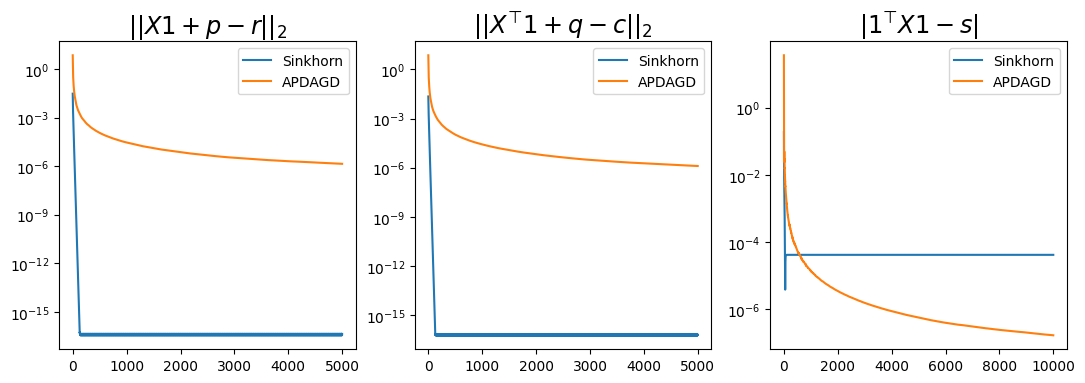

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))

X_sinkhorn = logs_sinkhorn["X"][1:]
X_apdagd = logs_apdagd["x"][1:]
X_de = [x[:int(n**2)].reshape((n, n)) for x in logs_de["x"][1:]]

# Row constraints
ax1.plot(logs_sinkhorn["row_cons_err"][::2], label="Sinkhorn")
ax1.plot(logs_apdagd["row_cons_err"][::2], label="APDAGD")
ax1.set_title("$\\|\\| X 1 + p - r \\|\\|_2$", size="xx-large")
ax1.set_yscale("log")
ax1.legend()

# Column constraints
ax2.plot(logs_sinkhorn["col_cons_err"][1::2], label="Sinkhorn")
ax2.plot(logs_apdagd["col_cons_err"][::2], label="APDAGD")
ax2.set_title("$\\|\\| X^\\top 1 + q - c \\|\\|_2$", size="xx-large")
ax2.set_yscale("log")
ax2.legend()

# Total mass constraints
ax3.plot(logs_sinkhorn["total_mass_err"], label="Sinkhorn")
ax3.plot(logs_apdagd["total_mass_err"], label="APDAGD")
ax3.set_title("$\\| 1^\\top X 1 - s \\|$", size="xx-large")
ax3.set_yscale("log")
ax3.legend()

plt.show()

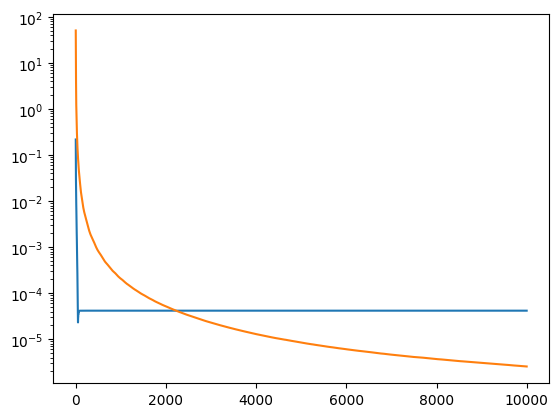

In [19]:
plt.plot(np.array(logs_sinkhorn["row_cons_err"]) +
         np.array(logs_sinkhorn["col_cons_err"]) +
         np.array(logs_sinkhorn["total_mass_err"]))

plt.plot(np.array(logs_apdagd["row_cons_err"]) +
         np.array(logs_apdagd["col_cons_err"]) +
         np.array(logs_apdagd["total_mass_err"]))
plt.yscale("log")

In [105]:
from pot_solvers import round_matrix
def round_sinkhorn_after_altschuler(X, r, c, s):
    n = X.shape[0] - 1
    X_ = X[:n, :n]
    p_ = X[:n, -1]
    q_ = X[-1, :n]
    return round_matrix(np.concatenate((X_.flatten(), p_, q_)), r, c, s)
X_sinkhorn_rounded = [round_sinkhorn_after_altschuler(X, source_hist, target_hist, s)[0]
                      for X in logs_sinkhorn["X"]]

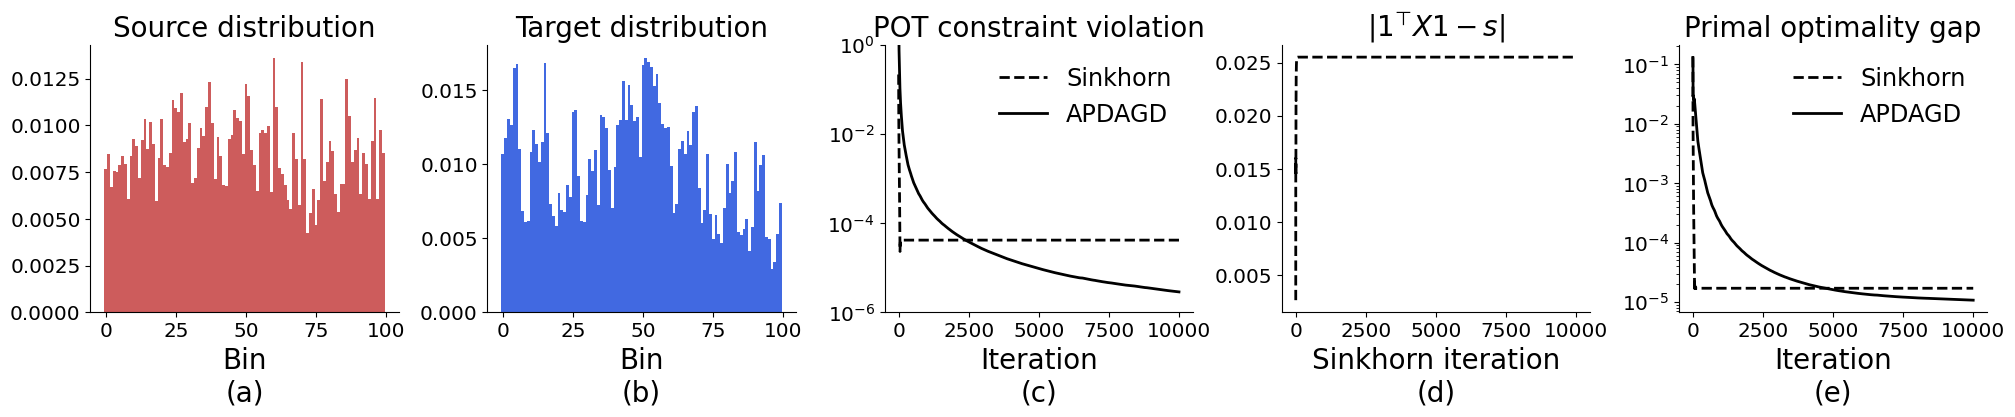

In [106]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))

# Marginal distributions
# Plot source distribution
ax1.bar(np.arange(len(source_hist)), source_hist, width=1,
        color="indianred",
        label="Source distribution")
ax1.set_title("Source distribution", size=20)
ax1.set_xlabel("Bin\n(a)", size=20)
ax1.tick_params(axis='x', which='major', labelsize="x-large")
ax1.tick_params(axis='y', which='major', labelsize="x-large")
sns.despine(ax=ax1)

# Plot target distribution
ax2.bar(np.arange(len(target_hist)), target_hist, width=1,
        color="royalblue",
        label="Target distribution")
ax2.set_title("Target distribution", size=20)
ax2.set_xlabel("Bin\n(b)", size=20)
ax2.tick_params(axis='x', which='major', labelsize="x-large")
ax2.tick_params(axis='y', which='major', labelsize="x-large")
sns.despine(ax=ax2)

# Polytope distance
ax3.plot(np.array(logs_sinkhorn["row_cons_err"]) +
         np.array(logs_sinkhorn["col_cons_err"]) +
         np.array(logs_sinkhorn["total_mass_err"]),
         color="black", linestyle="dashed", linewidth=2, label="Sinkhorn")
ax3.plot(np.array(logs_apdagd["row_cons_err"]) +
         np.array(logs_apdagd["col_cons_err"]) +
         np.array(logs_apdagd["total_mass_err"]),
         color="black", linestyle="solid", linewidth=2, label="APDAGD")
ax3.set_yscale("log")
ax3.set_title("POT constraint violation", size=20)
ax3.set_xlabel("Iteration\n(c)", size=20)
ax3.tick_params(axis='x', which='major', labelsize="x-large")
ax3.legend(prop={'size': "xx-large"}, frameon=False)
ax3.set_ylim([1e-6, 1e0])
ax3.tick_params(axis='y', which='major', labelsize="x-large")
sns.despine(ax=ax3)

# Total mass constraint
ax4.plot(logs_sinkhorn["A"], color="black", linestyle="dashed", linewidth=2,)
ax4.set_title("$\\| 1^\\top X 1 - s \\|$", size=20)
ax4.set_xlabel("Sinkhorn iteration\n(d)", size=20)
ax4.set_yscale("linear")
ax4.tick_params(axis='x', which='major', labelsize="x-large")
ax4.tick_params(axis='y', which='major', labelsize="x-large")
sns.despine(ax=ax4)

ax5.plot([np.sum(C * X) - f_star for X in X_sinkhorn_rounded], label="Sinkhorn",
         color="black", linestyle="dashed", linewidth=2)
ax5.plot([f - f_star for f in logs_apdagd["CX"]][:], label="APDAGD",
         color="black", linestyle="solid", linewidth=2,)
ax5.set_yscale("log")
ax5.tick_params(axis='x', which='major', labelsize="x-large")
ax5.legend(prop={'size': "xx-large"}, frameon=False)
# ax5.set_ylim([1e-6, 1e0])
ax5.tick_params(axis='y', which='major', labelsize="x-large")
ax5.set_title("Primal optimality gap", size=20)
ax5.set_xlabel("Iteration\n(e)", size=20)
sns.despine(ax=ax5)

fig.tight_layout(pad=0.1, w_pad=0.1)

plt.savefig("figures/pot_sinkhorn_vs_apdagd.pdf", bbox_inches="tight")

plt.show()

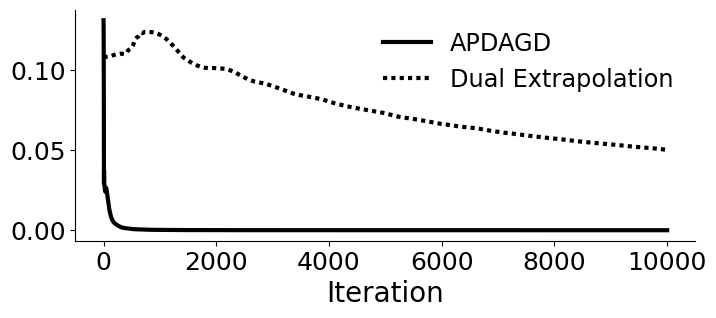

In [154]:
plt.figure(figsize=(8, 3))
plt.plot([f - f_star for f in logs_apdagd["CX"]][:], label="APDAGD",
         color="black", linestyle="solid", linewidth=3,)
# plt.plot([np.sum(C * X[:-1, :-1]) - f_star for X in X_sinkhorn], label="Sinkhorn")
plt.plot([np.sum(C * X[0]) - f_star for X in logs_de["transport_matrix"][1:]], 
         label="Dual Extrapolation",
         color="black", linestyle=(0, (1,1)), linewidth=3,)
# plt.yscale("log")
# plt.xscale("log")
plt.legend(prop={'size': "xx-large"}, frameon=False, loc="best")
sns.despine()
plt.xticks([0, 2000, 4000, 6000, 8000, 10000], size=18)
plt.yticks([0, 0.05, 0.1], size=18)
# plt.title("Primal optimality gap", size=20)
plt.xlabel("Iteration", size=20)
# plt.ylim([1e-5, 1e-3])
plt.savefig("figures/de_vs_apdagd_primal_gap.pdf", bbox_inches="tight")
plt.show()

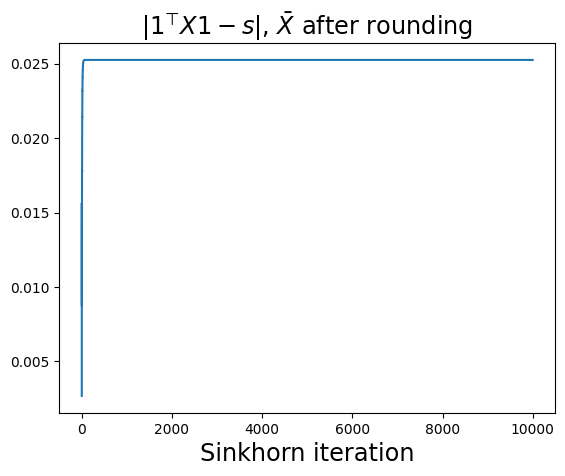

In [62]:
plt.plot(logs_sinkhorn["A"])
plt.title("$\\| 1^\\top X 1 - s \\|$, $\\bar{X}$ after rounding", size="xx-large")
plt.xlabel("Sinkhorn iteration", size="xx-large")
plt.yscale("linear")
plt.show()